In [11]:
import os
from matplotlib import pyplot
from numpy import vstack
from numpy import argmax
from pandas import read_csv
from sklearn.metrics import accuracy_score
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize
from torch.utils.data import DataLoader
from torch.nn import Conv2d, MaxPool2d, Linear, ReLU, Softmax, Module
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from torch.nn.init import kaiming_uniform_, xavier_uniform_
import torch

# 检查是否有GPU可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0),"is available")
else:
    print("GPU不可用，使用CPU")



# 模型定义
class CNN(Module):
    # 定义模型属性
    def __init__(self, n_channels):
        super(CNN, self).__init__()
        self.hidden1 = Conv2d(n_channels, 32, (3, 3))
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        self.pool1 = MaxPool2d((2, 2), stride=(2, 2))
        self.hidden2 = Conv2d(32, 32, (3, 3))
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        self.act2 = ReLU()
        self.pool2 = MaxPool2d((2, 2), stride=(2, 2))
        self.hidden3 = Linear(5 * 5 * 32, 100)
        kaiming_uniform_(self.hidden3.weight, nonlinearity='relu')
        self.act3 = ReLU()
        self.hidden4 = Linear(100, 10)
        xavier_uniform_(self.hidden4.weight)
        self.act4 = Softmax(dim=1)

        # 前向传播

    def forward(self, X):
        X = self.hidden1(X)
        X = self.act1(X)
        X = self.pool1(X)
        X = self.hidden2(X)
        X = self.act2(X)
        X = self.pool2(X)
        X = X.view(-1, 5 * 5 * 32)
        X = self.hidden3(X)
        X = self.act3(X)
        X = self.hidden4(X)
        X = self.act4(X)
        return X

# 准备数据集
def prepare_data(path):
    trans = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])
    train = MNIST(path, train=True, download=True, transform=trans)
    test = MNIST(path, train=False, download=True, transform=trans)
    train_dl = DataLoader(train, batch_size=64, shuffle=True)
    test_dl = DataLoader(test, batch_size=1024, shuffle=False)
    i, (inputs, targets) = next(enumerate(train_dl))
    for i in range(25):
        pyplot.subplot(5, 5, i + 1)
        pyplot.imshow(inputs[i][0], cmap='gray')
    print("Data loading...")
    pyplot.show()
    return train_dl, test_dl


# 训练模型
def train_model(train_dl, model):
    criterion = CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=0.012, momentum=0.85)
    for epoch in range(10):
        for i, (inputs, targets) in enumerate(train_dl):
            inputs, targets = inputs.to(device), targets.to(device)  # 将数据转移到GPU
            optimizer.zero_grad()
            yhat = model(inputs)
            loss = criterion(yhat, targets)
            loss.backward()
            optimizer.step()
            if i % 200 == 0:
                print('Train Epoch: {} [{:6d}/{} ({:2.0f}%)]\tLoss: {:2.6f}'.format(epoch,  i * len(inputs), len(train_dl.dataset),100. * i / len(train_dl), loss.item()))


# 评估模型
def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        inputs, targets = inputs.to(device), targets.to(device)  # 将数据转移到GPU
        yhat = model(inputs)
        yhat = yhat.detach().cpu().numpy()  # 将结果转移回CPU进行计算
        actual = targets.cpu().numpy()
        yhat = argmax(yhat, axis=1)
        actual = actual.reshape((len(actual), 1))
        yhat = yhat.reshape((len(yhat), 1))
        predictions.append(yhat)
        actuals.append(actual)

    predictions, actuals = vstack(predictions), vstack(actuals)
    acc = accuracy_score(actuals, predictions)
    return acc


NVIDIA GeForce RTX 3060 Laptop GPU is available


Data loading...


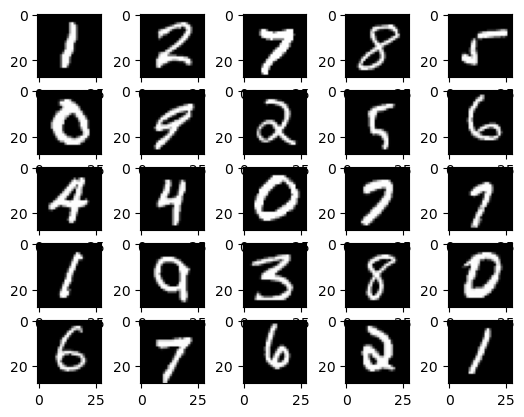

Number of training samples: 60000
Number of test samples: 10000


In [12]:
# 准备数据
path = os.path.join(os.getcwd(), 'datasets/mnist')
train_dl, test_dl = prepare_data(path)
print("Number of training samples:", len(train_dl.dataset))
print("Number of test samples:", len(test_dl.dataset))

In [13]:
# 定义网络并移动到GPU
model = CNN(1).to(device)
print("CNN Network Definition Complete")

CNN Network Definition Complete


In [14]:
# 训练模型
print("Model training...")
train_model(train_dl, model)
print("CNN Network Training Complete")

Model training...
Train Epoch: 0 [     0/60000 (0%)]	Loss: 2.322292
Train Epoch: 0 [ 12800/60000 (21%)]	Loss: 1.706031
Train Epoch: 0 [ 25600/60000 (43%)]	Loss: 1.693283
Train Epoch: 0 [ 38400/60000 (64%)]	Loss: 1.655425
Train Epoch: 0 [ 51200/60000 (85%)]	Loss: 1.704165
Train Epoch: 1 [     0/60000 (0%)]	Loss: 1.638590
Train Epoch: 1 [ 12800/60000 (21%)]	Loss: 1.638000
Train Epoch: 1 [ 25600/60000 (43%)]	Loss: 1.595530
Train Epoch: 1 [ 38400/60000 (64%)]	Loss: 1.646472
Train Epoch: 1 [ 51200/60000 (85%)]	Loss: 1.640022
Train Epoch: 2 [     0/60000 (0%)]	Loss: 1.599574
Train Epoch: 2 [ 12800/60000 (21%)]	Loss: 1.582917
Train Epoch: 2 [ 25600/60000 (43%)]	Loss: 1.540277
Train Epoch: 2 [ 38400/60000 (64%)]	Loss: 1.570287
Train Epoch: 2 [ 51200/60000 (85%)]	Loss: 1.524585
Train Epoch: 3 [     0/60000 (0%)]	Loss: 1.554489
Train Epoch: 3 [ 12800/60000 (21%)]	Loss: 1.533216
Train Epoch: 3 [ 25600/60000 (43%)]	Loss: 1.525884
Train Epoch: 3 [ 38400/60000 (64%)]	Loss: 1.580260
Train Epoch: 3 [ 

In [15]:
# 评估模型
acc = evaluate_model(test_dl, model)
print('CNN Network accuracy: %.3f' % acc)

CNN Network accuracy: 0.986
